In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.01 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 37138 
    Total predicted counts          : 36993.34
    Total off counts                : 101421.00

    Total background counts         : 20284.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 2000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 7.87 s, sys: 51.8 ms, total: 7.93 s
Wall time: 7.95 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 37031 
    Total predicted counts          : 37041.14
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 36776 
    Total predicted counts          : 36975.54
    Total off counts                : 101332.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_23 

    Total counts                    : 37158 
    Total predicted counts          : 36968.94
    Total off counts                : 101299.00

    Total background counts         : 20259.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_24 

    Total counts                    : 37251 
    Total predicted counts          : 36990.54
    Total off counts                : 101407.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_44 

    Total counts                    : 37161 
    Total predicted counts          : 37082.94
    Total off counts                : 101869.00

    Total background counts         : 20373.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_45 

    Total counts                    : 36903 
    Total predicted counts          : 37012.54
    Total off counts                : 101517.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_64 

    Total counts                    : 36998 
    Total predicted counts          : 37013.34
    Total off counts                : 101521.00

    Total background counts         : 20304.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_65 

    Total counts                    : 36676 
    Total predicted counts          : 36906.54
    Total off counts                : 100987.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_82 

    Total counts                    : 36726 
    Total predicted counts          : 37007.74
    Total off counts                : 101493.00

    Total background counts         : 20298.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_83 

    Total counts                    : 36859 
    Total predicted counts          : 37164.14
    Total off counts                : 102275.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_106 

    Total counts                    : 37016 
    Total predicted counts          : 37078.94
    Total off counts                : 101849.00

    Total background counts         : 20369.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_107 

    Total counts                    : 36678 
    Total predicted counts          : 37101.54
    Total off counts                : 101962.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_135 

    Total counts                    : 37182 
    Total predicted counts          : 36970.54
    Total off counts                : 101307.00

    Total background counts         : 20261.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_136 

    Total counts                    : 36791 
    Total predicted counts          : 37045.54
    Total off counts                : 101682.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_165 

    Total counts                    : 37323 
    Total predicted counts          : 37100.74
    Total off counts                : 101958.00

    Total background counts         : 20391.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_166 

    Total counts                    : 37101 
    Total predicted counts          : 37048.14
    Total off counts                : 101695.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_195 

    Total counts                    : 36917 
    Total predicted counts          : 37097.74
    Total off counts                : 101943.00

    Total background counts         : 20388.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_196 

    Total counts                    : 37076 
    Total predicted counts          : 37039.54
    Total off counts                : 101652.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_221 

    Total counts                    : 36987 
    Total predicted counts          : 36998.54
    Total off counts                : 101447.00

    Total background counts         : 20289.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_222 

    Total counts                    : 37161 
    Total predicted counts          : 36996.54
    Total off counts                : 101437.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_251 

    Total counts                    : 37169 
    Total predicted counts          : 37038.54
    Total off counts                : 101647.00

    Total background counts         : 20329.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_252 

    Total counts                    : 36884 
    Total predicted counts          : 37077.74
    Total off counts                : 101843.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_281 

    Total counts                    : 36821 
    Total predicted counts          : 37032.14
    Total off counts                : 101615.00

    Total background counts         : 20323.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_282 

    Total counts                    : 36987 
    Total predicted counts          : 37049.74
    Total off counts                : 101703.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_313 

    Total counts                    : 37295 
    Total predicted counts          : 37073.74
    Total off counts                : 101823.00

    Total background counts         : 20364.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_314 

    Total counts                    : 37334 
    Total predicted counts          : 36916.94
    Total off counts                : 101039.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_343 

    Total counts                    : 37073 
    Total predicted counts          : 36997.34
    Total off counts                : 101441.00

    Total background counts         : 20288.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_344 

    Total counts                    : 36591 
    Total predicted counts          : 37033.14
    Total off counts                : 101620.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_370 

    Total counts                    : 37121 
    Total predicted counts          : 37110.34
    Total off counts                : 102006.00

    Total background counts         : 20401.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_371 

    Total counts                    : 37067 
    Total predicted counts          : 37028.14
    Total off counts                : 101595.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_398 

    Total counts                    : 37211 
    Total predicted counts          : 37120.54
    Total off counts                : 102057.00

    Total background counts         : 20411.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_399 

    Total counts                    : 36841 
    Total predicted counts          : 36968.54
    Total off counts                : 101297.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_429 

    Total counts                    : 36965 
    Total predicted counts          : 36922.14
    Total off counts                : 101065.00

    Total background counts         : 20213.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_430 

    Total counts                    : 37129 
    Total predicted counts          : 36995.54
    Total off counts                : 101432.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_460 

    Total counts                    : 37078 
    Total predicted counts          : 37093.74
    Total off counts                : 101923.00

    Total background counts         : 20384.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_461 

    Total counts                    : 36716 
    Total predicted counts          : 37081.54
    Total off counts                : 101862.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_490 

    Total counts                    : 36886 
    Total predicted counts          : 37010.94
    Total off counts                : 101509.00

    Total background counts         : 20301.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_491 

    Total counts                    : 36825 
    Total predicted counts          : 37061.14
    Total off counts                : 101760.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_520 

    Total counts                    : 36927 
    Total predicted counts          : 37023.94
    Total off counts                : 101574.00

    Total background counts         : 20314.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_521 

    Total counts                    : 37446 
    Total predicted counts          : 37029.74
    Total off counts                : 101603.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_542 

    Total counts                    : 36927 
    Total predicted counts          : 36969.14
    Total off counts                : 101300.00

    Total background counts         : 20260.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_543 

    Total counts                    : 36822 
    Total predicted counts          : 37009.14
    Total off counts                : 101500.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_554 

    Total counts                    : 36986 
    Total predicted counts          : 37063.74
    Total off counts                : 101773.00

    Total background counts         : 20354.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_555 

    Total counts                    : 37199 
    Total predicted counts          : 36907.34
    Total off counts                : 100991.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_574 

    Total counts                    : 37153 
    Total predicted counts          : 37076.54
    Total off counts                : 101837.00

    Total background counts         : 20367.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_575 

    Total counts                    : 36873 
    Total predicted counts          : 37100.74
    Total off counts                : 101958.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_602 

    Total counts                    : 37228 
    Total predicted counts          : 37013.34
    Total off counts                : 101521.00

    Total background counts         : 20304.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_603 

    Total counts                    : 36863 
    Total predicted counts          : 36979.54
    Total off counts                : 101352.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_613 

    Total counts                    : 36901 
    Total predicted counts          : 37085.94
    Total off counts                : 101884.00

    Total background counts         : 20376.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_614 

    Total counts                    : 37215 
    Total predicted counts          : 37095.14
    Total off counts                : 101930.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_633 

    Total counts                    : 36996 
    Total predicted counts          : 36990.94
    Total off counts                : 101409.00

    Total background counts         : 20281.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_634 

    Total counts                    : 36992 
    Total predicted counts          : 37079.74
    Total off counts                : 101853.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_644 

    Total counts                    : 36859 
    Total predicted counts          : 37073.14
    Total off counts                : 101820.00

    Total background counts         : 20364.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_645 

    Total counts                    : 37097 
    Total predicted counts          : 37117.94
    Total off counts                : 102044.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_664 

    Total counts                    : 36771 
    Total predicted counts          : 37054.54
    Total off counts                : 101727.00

    Total background counts         : 20345.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_665 

    Total counts                    : 36875 
    Total predicted counts          : 36964.94
    Total off counts                : 101279.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_676 

    Total counts                    : 37045 
    Total predicted counts          : 36927.74
    Total off counts                : 101093.00

    Total background counts         : 20218.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_677 

    Total counts                    : 37063 
    Total predicted counts          : 37032.94
    Total off counts                : 101619.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_694 

    Total counts                    : 37234 
    Total predicted counts          : 36972.94
    Total off counts                : 101319.00

    Total background counts         : 20263.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_695 

    Total counts                    : 37021 
    Total predicted counts          : 36939.14
    Total off counts                : 101150.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_706 

    Total counts                    : 37014 
    Total predicted counts          : 37151.94
    Total off counts                : 102214.00

    Total background counts         : 20442.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_707 

    Total counts                    : 36854 
    Total predicted counts          : 36965.94
    Total off counts                : 101284.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_721 

    Total counts                    : 36827 
    Total predicted counts          : 37086.14
    Total off counts                : 101885.00

    Total background counts         : 20377.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_722 

    Total counts                    : 36788 
    Total predicted counts          : 36942.94
    Total off counts                : 101169.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_735 

    Total counts                    : 37166 
    Total predicted counts          : 37019.34
    Total off counts                : 101551.00

    Total background counts         : 20310.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_736 

    Total counts                    : 37159 
    Total predicted counts          : 37084.54
    Total off counts                : 101877.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_752 

    Total counts                    : 37199 
    Total predicted counts          : 36957.34
    Total off counts                : 101241.00

    Total background counts         : 20248.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_753 

    Total counts                    : 36878 
    Total predicted counts          : 36990.54
    Total off counts                : 101407.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_765 

    Total counts                    : 36869 
    Total predicted counts          : 36994.54
    Total off counts                : 101427.00

    Total background counts         : 20285.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_766 

    Total counts                    : 36813 
    Total predicted counts          : 36993.14
    Total off counts                : 101420.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_784 

    Total counts                    : 36922 
    Total predicted counts          : 37021.14
    Total off counts                : 101560.00

    Total background counts         : 20312.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_785 

    Total counts                    : 36680 
    Total predicted counts          : 36980.94
    Total off counts                : 101359.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_804 

    Total counts                    : 37201 
    Total predicted counts          : 36978.34
    Total off counts                : 101346.00

    Total background counts         : 20269.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_805 

    Total counts                    : 36874 
    Total predicted counts          : 37040.94
    Total off counts                : 101659.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_823 

    Total counts                    : 37506 
    Total predicted counts          : 36995.94
    Total off counts                : 101434.00

    Total background counts         : 20286.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 21.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_824 

    Total counts                    : 37075 
    Total predicted counts          : 36999.54
    Total off counts                : 101452.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_836 

    Total counts                    : 37501 
    Total predicted counts          : 36978.94
    Total off counts                : 101349.00

    Total background counts         : 20269.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_837 

    Total counts                    : 37014 
    Total predicted counts          : 36907.34
    Total off counts                : 100991.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_852 

    Total counts                    : 37005 
    Total predicted counts          : 37077.54
    Total off counts                : 101842.00

    Total background counts         : 20368.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_853 

    Total counts                    : 37092 
    Total predicted counts          : 37102.14
    Total off counts                : 101965.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_866 

    Total counts                    : 37195 
    Total predicted counts          : 37066.74
    Total off counts                : 101788.00

    Total background counts         : 20357.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_867 

    Total counts                    : 36775 
    Total predicted counts          : 36955.34
    Total off counts                : 101231.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_883 

    Total counts                    : 36914 
    Total predicted counts          : 36944.14
    Total off counts                : 101175.00

    Total background counts         : 20235.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_884 

    Total counts                    : 37060 
    Total predicted counts          : 36931.54
    Total off counts                : 101112.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_897 

    Total counts                    : 37239 
    Total predicted counts          : 36912.54
    Total off counts                : 101017.00

    Total background counts         : 20203.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_898 

    Total counts                    : 36933 
    Total predicted counts          : 36979.74
    Total off counts                : 101353.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_912 

    Total counts                    : 37089 
    Total predicted counts          : 36980.74
    Total off counts                : 101358.00

    Total background counts         : 20271.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_913 

    Total counts                    : 37061 
    Total predicted counts          : 36968.54
    Total off counts                : 101297.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_926 

    Total counts                    : 37030 
    Total predicted counts          : 37037.14
    Total off counts                : 101640.00

    Total background counts         : 20328.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_927 

    Total counts                    : 37174 
    Total predicted counts          : 36868.54
    Total off counts                : 100797.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_941 

    Total counts                    : 36937 
    Total predicted counts          : 37058.34
    Total off counts                : 101746.00

    Total background counts         : 20349.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_942 

    Total counts                    : 36874 
    Total predicted counts          : 37032.94
    Total off counts                : 101619.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_957 

    Total counts                    : 37498 
    Total predicted counts          : 36971.14
    Total off counts                : 101310.00

    Total background counts         : 20262.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_958 

    Total counts                    : 36920 
    Total predicted counts          : 36997.74
    Total off counts                : 101443.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_972 

    Total counts                    : 36855 
    Total predicted counts          : 37081.54
    Total off counts                : 101862.00

    Total background counts         : 20372.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_973 

    Total counts                    : 37136 
    Total predicted counts          : 36934.14
    Total off counts                : 101125.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_986 

    Total counts                    : 37148 
    Total predicted counts          : 37014.74
    Total off counts                : 101528.00

    Total background counts         : 20305.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_987 

    Total counts                    : 37242 
    Total predicted counts          : 37034.34
    Total off counts                : 101626.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_1003 

    Total counts                    : 37062 
    Total predicted counts          : 36984.74
    Total off counts                : 101378.00

    Total background counts         : 20275.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1004 

    Total counts                    : 36869 
    Total predicted counts          : 37031.54
    Total off counts                : 101612.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1017 

    Total counts                    : 37317 
    Total predicted counts          : 37062.94
    Total off counts                : 101769.00

    Total background counts         : 20353.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1018 

    Total counts                    : 36850 
    Total predicted counts          : 37099.14
    Total off counts                : 101950.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1032 

    Total counts                    : 36990 
    Total predicted counts          : 37078.74
    Total off counts                : 101848.00

    Total background counts         : 20369.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1033 

    Total counts                    : 36984 
    Total predicted counts          : 37066.74
    Total off counts                : 101788.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1047 

    Total counts                    : 37071 
    Total predicted counts          : 37103.94
    Total off counts                : 101974.00

    Total background counts         : 20394.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1048 

    Total counts                    : 36722 
    Total predicted counts          : 36928.34
    Total off counts                : 101096.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1065 

    Total counts                    : 36522 
    Total predicted counts          : 37064.94
    Total off counts                : 101779.00

    Total background counts         : 20355.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1066 

    Total counts                    : 37174 
    Total predicted counts          : 37065.74
    Total off counts                : 101783.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1078 

    Total counts                    : 36975 
    Total predicted counts          : 37022.34
    Total off counts                : 101566.00

    Total background counts         : 20313.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1079 

    Total counts                    : 37148 
    Total predicted counts          : 37107.94
    Total off counts                : 101994.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1098 

    Total counts                    : 36892 
    Total predicted counts          : 36996.14
    Total off counts                : 101435.00

    Total background counts         : 20287.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1099 

    Total counts                    : 37241 
    Total predicted counts          : 37058.74
    Total off counts                : 101748.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1128 

    Total counts                    : 37213 
    Total predicted counts          : 36975.34
    Total off counts                : 101331.00

    Total background counts         : 20266.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1129 

    Total counts                    : 36898 
    Total predicted counts          : 36921.34
    Total off counts                : 101061.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1157 

    Total counts                    : 36951 
    Total predicted counts          : 37040.74
    Total off counts                : 101658.00

    Total background counts         : 20331.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1158 

    Total counts                    : 37042 
    Total predicted counts          : 37141.94
    Total off counts                : 102164.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1168 

    Total counts                    : 37075 
    Total predicted counts          : 36921.74
    Total off counts                : 101063.00

    Total background counts         : 20212.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1169 

    Total counts                    : 36801 
    Total predicted counts          : 36985.14
    Total off counts                : 101380.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1188 

    Total counts                    : 37120 
    Total predicted counts          : 37020.14
    Total off counts                : 101555.00

    Total background counts         : 20311.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1189 

    Total counts                    : 37148 
    Total predicted counts          : 37034.34
    Total off counts                : 101626.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1217 

    Total counts                    : 36754 
    Total predicted counts          : 37075.94
    Total off counts                : 101834.00

    Total background counts         : 20366.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1218 

    Total counts                    : 37212 
    Total predicted counts          : 37005.54
    Total off counts                : 101482.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1228 

    Total counts                    : 37137 
    Total predicted counts          : 37152.34
    Total off counts                : 102216.00

    Total background counts         : 20443.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1229 

    Total counts                    : 36760 
    Total predicted counts          : 37021.14
    Total off counts                : 101560.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1253 

    Total counts                    : 37267 
    Total predicted counts          : 36909.14
    Total off counts                : 101000.00

    Total background counts         : 20200.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1254 

    Total counts                    : 37167 
    Total predicted counts          : 36981.94
    Total off counts                : 101364.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1284 

    Total counts                    : 37207 
    Total predicted counts          : 36995.74
    Total off counts                : 101433.00

    Total background counts         : 20286.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1285 

    Total counts                    : 36761 
    Total predicted counts          : 37017.54
    Total off counts                : 101542.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1314 

    Total counts                    : 36912 
    Total predicted counts          : 37035.54
    Total off counts                : 101632.00

    Total background counts         : 20326.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1315 

    Total counts                    : 37061 
    Total predicted counts          : 36920.74
    Total off counts                : 101058.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1345 

    Total counts                    : 36668 
    Total predicted counts          : 36939.14
    Total off counts                : 101150.00

    Total background counts         : 20230.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1346 

    Total counts                    : 37147 
    Total predicted counts          : 36979.94
    Total off counts                : 101354.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1373 

    Total counts                    : 37028 
    Total predicted counts          : 37137.94
    Total off counts                : 102144.00

    Total background counts         : 20428.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1374 

    Total counts                    : 36811 
    Total predicted counts          : 36970.14
    Total off counts                : 101305.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1404 

    Total counts                    : 37126 
    Total predicted counts          : 36972.94
    Total off counts                : 101319.00

    Total background counts         : 20263.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1405 

    Total counts                    : 36850 
    Total predicted counts          : 37124.14
    Total off counts                : 102075.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1434 

    Total counts                    : 37120 
    Total predicted counts          : 36971.74
    Total off counts                : 101313.00

    Total background counts         : 20262.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1435 

    Total counts                    : 37194 
    Total predicted counts          : 37065.54
    Total off counts                : 101782.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1463 

    Total counts                    : 36569 
    Total predicted counts          : 36968.34
    Total off counts                : 101296.00

    Total background counts         : 20259.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1464 

    Total counts                    : 37141 
    Total predicted counts          : 36958.34
    Total off counts                : 101246.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1493 

    Total counts                    : 36966 
    Total predicted counts          : 36966.34
    Total off counts                : 101286.00

    Total background counts         : 20257.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1494 

    Total counts                    : 37272 
    Total predicted counts          : 37079.14
    Total off counts                : 101850.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1527 

    Total counts                    : 36807 
    Total predicted counts          : 37122.94
    Total off counts                : 102069.00

    Total background counts         : 20413.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1528 

    Total counts                    : 37044 
    Total predicted counts          : 37082.74
    Total off counts                : 101868.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1557 

    Total counts                    : 36842 
    Total predicted counts          : 37068.74
    Total off counts                : 101798.00

    Total background counts         : 20359.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1558 

    Total counts                    : 36971 
    Total predicted counts          : 36966.74
    Total off counts                : 101288.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1586 

    Total counts                    : 37421 
    Total predicted counts          : 36995.34
    Total off counts                : 101431.00

    Total background counts         : 20286.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1587 

    Total counts                    : 37143 
    Total predicted counts          : 37002.34
    Total off counts                : 101466.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1617 

    Total counts                    : 37040 
    Total predicted counts          : 36997.14
    Total off counts                : 101440.00

    Total background counts         : 20288.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1618 

    Total counts                    : 36630 
    Total predicted counts          : 37013.54
    Total off counts                : 101522.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1646 

    Total counts                    : 37450 
    Total predicted counts          : 37020.54
    Total off counts                : 101557.00

    Total background counts         : 20311.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1647 

    Total counts                    : 36846 
    Total predicted counts          : 37007.14
    Total off counts                : 101490.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1676 

    Total counts                    : 37081 
    Total predicted counts          : 37007.14
    Total off counts                : 101490.00

    Total background counts         : 20298.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1677 

    Total counts                    : 37131 
    Total predicted counts          : 37067.34
    Total off counts                : 101791.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1706 

    Total counts                    : 37142 
    Total predicted counts          : 37097.94
    Total off counts                : 101944.00

    Total background counts         : 20388.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1707 

    Total counts                    : 37154 
    Total predicted counts          : 37097.54
    Total off counts                : 101942.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1739 

    Total counts                    : 37203 
    Total predicted counts          : 36996.54
    Total off counts                : 101437.00

    Total background counts         : 20287.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1740 

    Total counts                    : 37058 
    Total predicted counts          : 37020.54
    Total off counts                : 101557.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1768 

    Total counts                    : 37185 
    Total predicted counts          : 37028.74
    Total off counts                : 101598.00

    Total background counts         : 20319.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1769 

    Total counts                    : 36848 
    Total predicted counts          : 37158.94
    Total off counts                : 102249.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1798 

    Total counts                    : 36962 
    Total predicted counts          : 36981.74
    Total off counts                : 101363.00

    Total background counts         : 20272.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1799 

    Total counts                    : 36931 
    Total predicted counts          : 37009.14
    Total off counts                : 101500.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1828 

    Total counts                    : 36930 
    Total predicted counts          : 37058.74
    Total off counts                : 101748.00

    Total background counts         : 20349.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1829 

    Total counts                    : 36775 
    Total predicted counts          : 37051.54
    Total off counts                : 101712.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1858 

    Total counts                    : 37075 
    Total predicted counts          : 36972.94
    Total off counts                : 101319.00

    Total background counts         : 20263.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1859 

    Total counts                    : 37026 
    Total predicted counts          : 37125.94
    Total off counts                : 102084.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_1889 

    Total counts                    : 36826 
    Total predicted counts          : 37155.34
    Total off counts                : 102231.00

    Total background counts         : 20446.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1890 

    Total counts                    : 36900 
    Total predicted counts          : 37010.34
    Total off counts                : 101506.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1920 

    Total counts                    : 36708 
    Total predicted counts          : 36973.94
    Total off counts                : 101324.00

    Total background counts         : 20264.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1921 

    Total counts                    : 37214 
    Total predicted counts          : 37012.54
    Total off counts                : 101517.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1949 

    Total counts                    : 36673 
    Total predicted counts          : 36947.74
    Total off counts                : 101193.00

    Total background counts         : 20238.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1950 

    Total counts                    : 36869 
    Total predicted counts          : 36970.54
    Total off counts                : 101307.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1978 

    Total counts                    : 36968 
    Total predicted counts          : 37047.14
    Total off counts                : 101690.00

    Total background counts         : 20338.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1979 

    Total counts                    : 37441 
    Total predicted counts          : 37042.54
    Total off counts                : 101667.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

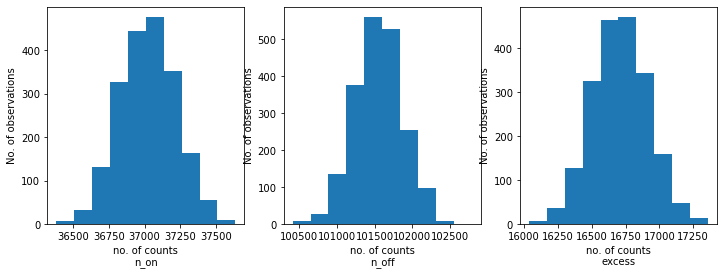

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 7min 38s, sys: 1.53 s, total: 7min 39s
Wall time: 7min 50s


In [15]:
results

[{'index': 2.203480656028608,
  'amplitude': 1.319131223495981e-12,
  'lambda_': 0.013352732699866327},
 {'index': 2.216551178307587,
  'amplitude': 1.2725453446582055e-12,
  'lambda_': 0.012480063961532253},
 {'index': 2.2335639880896676,
  'amplitude': 1.2564924970102983e-12,
  'lambda_': 0.0072483906282169285},
 {'index': 2.2237083872295806,
  'amplitude': 1.2773920002908233e-12,
  'lambda_': 0.010494121103543178},
 {'index': 2.23559148008517,
  'amplitude': 1.2791173736763305e-12,
  'lambda_': 0.007843659678971531},
 {'index': 2.218221845526143,
  'amplitude': 1.2812586132237533e-12,
  'lambda_': 0.009791377910732025},
 {'index': 2.226136664494706,
  'amplitude': 1.2713707997318236e-12,
  'lambda_': 0.005722998180854309},
 {'index': 2.2226220144232536,
  'amplitude': 1.275810972118856e-12,
  'lambda_': 0.008042198413201269},
 {'index': 2.2014059217857174,
  'amplitude': 1.3207168628601819e-12,
  'lambda_': 0.016130245144718953},
 {'index': 2.21359023766153,
  'amplitude': 1.2931702

index: 2.2201283797673916 += 0.008798436639941284


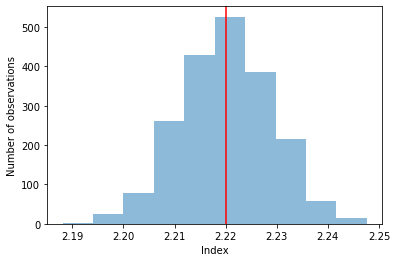

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2890984736330236e-12 += 1.8740852609441828e-14


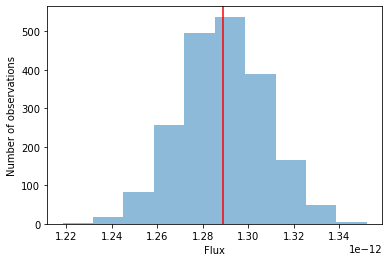

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.010090314776461247 += 0.0026633154300765654


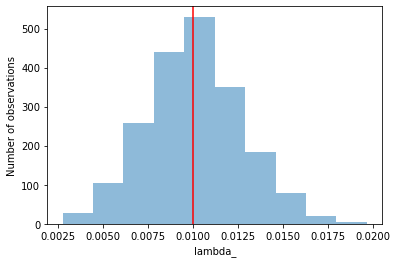

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")